<a href="https://colab.research.google.com/github/Suhaila-Hassan/Walmart-Sales-Analysis-and-Forecasting/blob/main/Research_and_Training_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
!pip install neuralforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.8/285.8 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.9/68.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import calendar
np.random.seed(42)

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, Conv1D, MaxPooling1D, Flatten, SimpleRNN, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from prophet import Prophet

from neuralforecast.models import NBEATSx
from neuralforecast import NeuralForecast
from neuralforecast.losses.pytorch import MSE

import joblib
import pickle

import warnings
warnings.filterwarnings('ignore')

# Load Dataset

In [3]:
from google.colab import files
uploaded = files.upload()

Saving dataset.csv to dataset.csv


In [4]:
df = pd.read_csv('dataset.csv')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df.head()

,Date,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment
0,2010-02-05,0,1.0,24924.50,42.31,2.572,211.096358,8.106
1,2010-02-05,0,26.0,11737.12,42.31,2.572,211.096358,8.106
2,2010-02-05,0,17.0,13223.76,42.31,2.572,211.096358,8.106
3,2010-02-05,0,45.0,37.44,42.31,2.572,211.096358,8.106
4,2010-02-05,0,28.0,1085.29,42.31,2.572,211.096358,8.106


# Dataset Preparation

In [5]:
# Set Date as Index
df = df.sort_values(by='Date', ascending=True).set_index('Date')
df.index = pd.to_datetime(df.index, format='%Y-%m-%d')

In [6]:
# Extract Department 23
df = df[df['Dept'] == 23]
df.drop(columns=['Dept'], inplace=True)

In [7]:
df.head()

,IsHoliday,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,
2010-02-05,0,24146.49,42.31,2.572,211.096358,8.106
2010-02-12,1,22812.41,38.51,2.548,211.242170,8.106
2010-02-19,0,21381.85,39.93,2.514,211.289143,8.106
2010-02-26,0,17798.37,46.63,2.561,211.319643,8.106
2010-03-05,0,18993.69,46.50,2.625,211.350143,8.106


# Dataset Information

In [8]:
df.shape

(143, 6)

In [9]:
df.shape[0] / 13

11.0

In [10]:
df.columns

Index(['IsHoliday', 'Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI',
       'Unemployment'],
      dtype='object')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 143 entries, 2010-02-05 to 2012-10-26
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   IsHoliday     143 non-null    int64  
 1   Weekly_Sales  143 non-null    float64
 2   Temperature   143 non-null    float64
 3   Fuel_Price    143 non-null    float64
 4   CPI           143 non-null    float64
 5   Unemployment  143 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 7.8 KB


In [12]:
df.describe()

,IsHoliday,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment
count,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000
mean,0.069930,21623.184685,68.306783,3.219699,215.996892,7.610420
std,0.255926,5973.220675,14.250486,0.427313,4.350890,0.383749
min,0.000000,13053.740000,35.400000,2.514000,210.337426,6.573000
25%,0.000000,18417.945000,58.265000,2.764500,211.549277,7.348000
50%,0.000000,20704.870000,69.640000,3.290000,215.459905,7.787000
75%,0.000000,23246.990000,80.485000,3.594000,220.531330,7.838000
max,1.000000,62381.000000,91.650000,3.907000,223.444251,8.106000


In [13]:
df.isna().sum()

,0
IsHoliday,0
Weekly_Sales,0
Temperature,0
Fuel_Price,0
CPI,0
Unemployment,0


In [14]:
df.duplicated().sum()

np.int64(0)

In [15]:
print(f'Date Range: from {df.index.min()} to {df.index.max()}')

Date Range: from 2010-02-05 00:00:00 to 2012-10-26 00:00:00


# Exploratory Data Analysis

In [16]:
max_idx = df['Weekly_Sales'].idxmax()
min_idx = df['Weekly_Sales'].idxmin()
max_val = df.loc[max_idx, 'Weekly_Sales']
min_val = df.loc[min_idx, 'Weekly_Sales']
print(f'Max Sales: {max_val:,.0f} on {max_idx}')
print(f'Min Sales: {min_val:,.0f} on {min_idx}')

Max Sales: 62,381 on 2010-12-24 00:00:00
Min Sales: 13,054 on 2011-09-16 00:00:00


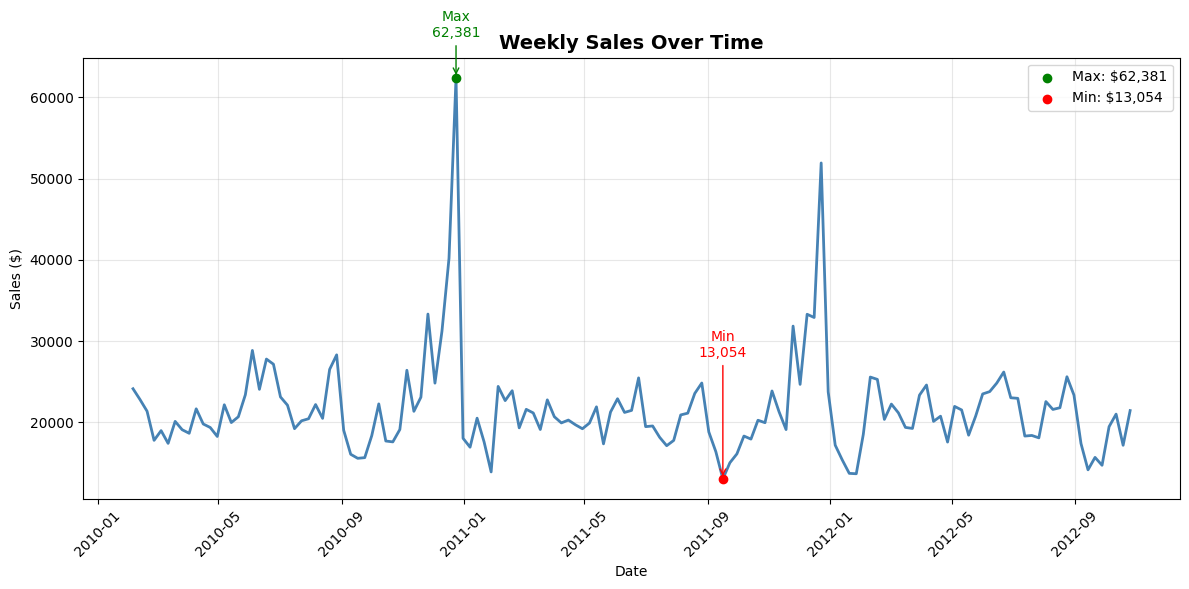

In [17]:
# Time Series Plot
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Weekly_Sales'], color='steelblue', linewidth=2)

plt.scatter([max_idx], [max_val], color='green', label=f'Max: ${max_val:,.0f}', zorder=5)
plt.scatter([min_idx], [min_val], color='red', label=f'Min: ${min_val:,.0f}', zorder=5)

plt.annotate(f'Max\n{max_val:,.0f}', xy=(max_idx, max_val), xytext=(max_idx, max_val + 5000),
             arrowprops=dict(arrowstyle='->', color='green'), fontsize=10, color='green', ha='center')

plt.annotate(f'Min\n{min_val:,.0f}', xy=(min_idx, min_val), xytext=(min_idx, min_val + 15000),
             arrowprops=dict(arrowstyle='->', color='red'), fontsize=10, color='red', ha='center')

plt.title('Weekly Sales Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Sales ($)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

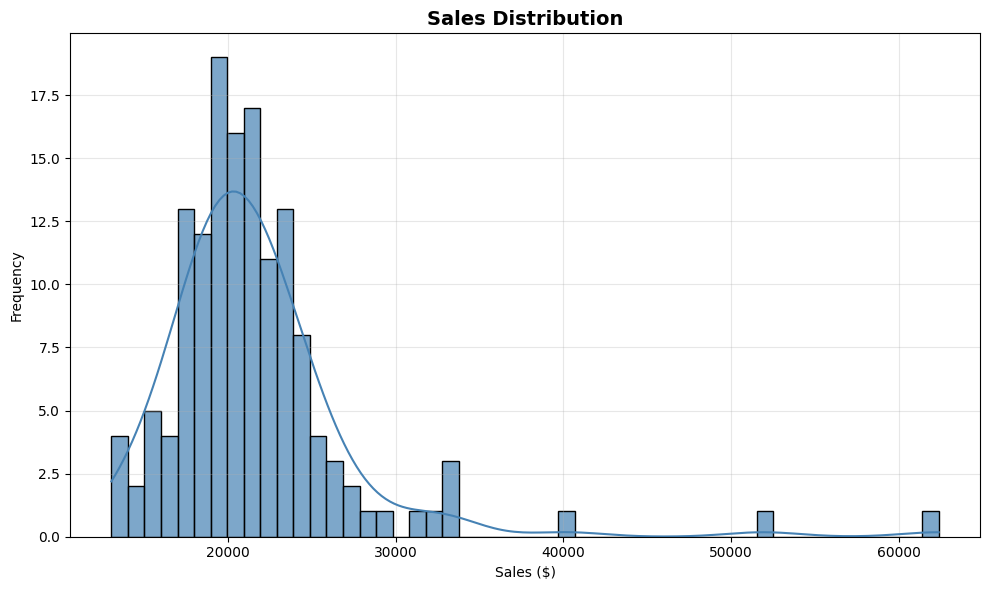

In [18]:
# Sales Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Weekly_Sales'], bins=50, kde=True, color='steelblue', edgecolor='black', alpha=0.7)
plt.title('Sales Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Sales ($)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

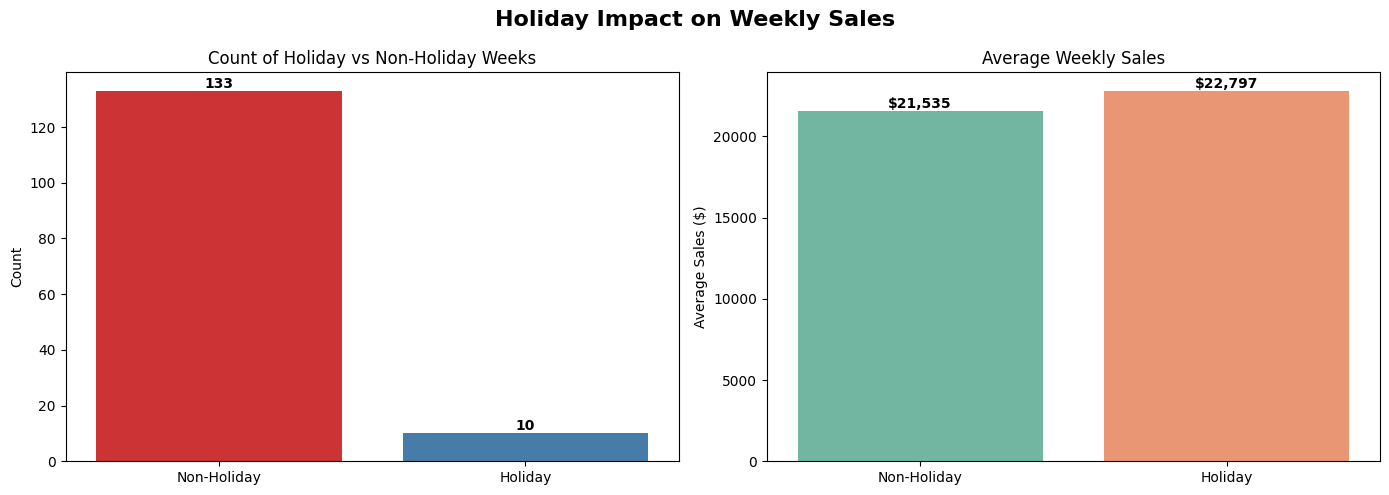

In [19]:
# Holiday Effect
holiday_counts = df['IsHoliday'].value_counts().rename({0: 'Non-Holiday', 1: 'Holiday'})
holiday_avg_sales = df.groupby('IsHoliday')['Weekly_Sales'].mean().rename({0: 'Non-Holiday', 1: 'Holiday'})

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Holiday Impact on Weekly Sales', fontsize=16, fontweight='bold')

sns.barplot(x=holiday_counts.index, y=holiday_counts.values, palette='Set1', ax=axes[0])
axes[0].set_title('Count of Holiday vs Non-Holiday Weeks')
axes[0].set_ylabel('Count')
axes[0].set_xlabel('')
for i, val in enumerate(holiday_counts.values):
    axes[0].text(i, val, f'{val}', ha='center', va='bottom', fontweight='bold')

sns.barplot(x=holiday_avg_sales.index, y=holiday_avg_sales.values, palette='Set2', ax=axes[1])
axes[1].set_title('Average Weekly Sales')
axes[1].set_ylabel('Average Sales ($)')
axes[1].set_xlabel('')
for i, val in enumerate(holiday_avg_sales.values):
    axes[1].text(i, val, f'${val:,.0f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [20]:
monthly_sales = df.groupby(df.index.month)['Weekly_Sales'].mean()
monthly_sales.index = [calendar.month_abbr[m] for m in monthly_sales.index]
max_month = monthly_sales.idxmax()
min_month = monthly_sales.idxmin()
max_value = monthly_sales[max_month]
min_value = monthly_sales[min_month]
print(f'Max Sales: {max_value:,.0f} in {max_month}')
print(f'Min Sales: {min_value:,.0f} in {min_month}')

Max Sales: 34,327 in Dec
Min Sales: 15,990 in Sep


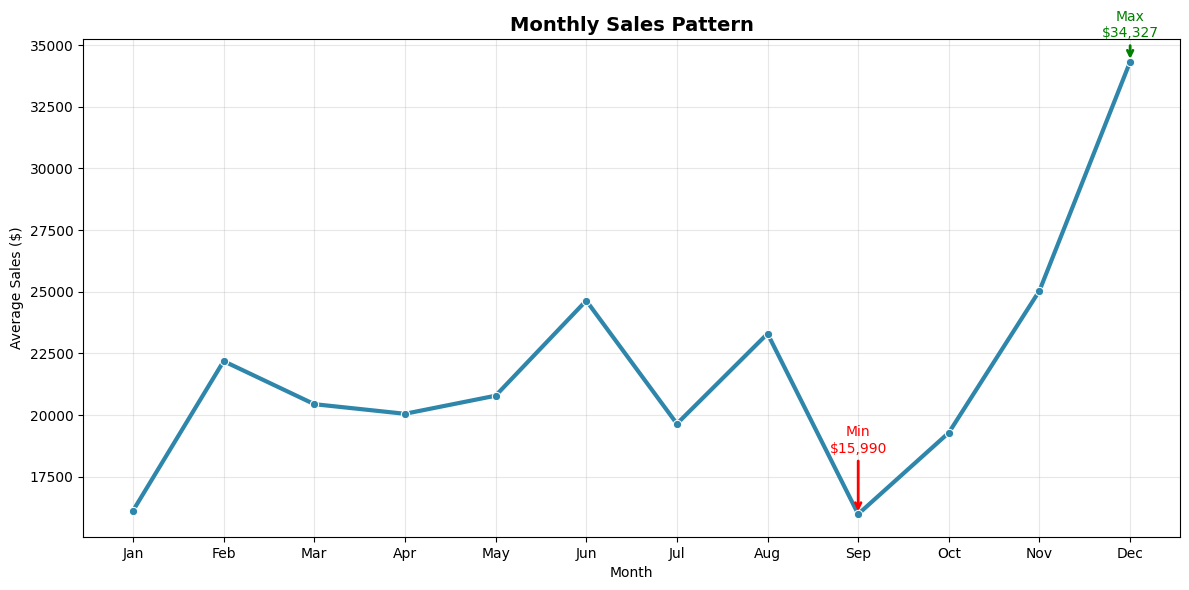

In [21]:
# Monthly Pattern
plt.figure(figsize=(12, 6))
sns.lineplot(x=monthly_sales.index, y=monthly_sales.values, marker='o', linewidth=3, color='#2E86AB')

plt.annotate(f'Max\n${max_value:,.0f}',
             xy=(max_month, max_value),
             xytext=(max_month, max_value + 1000),
             textcoords='data',
             arrowprops=dict(arrowstyle='->', color='green', lw=2),
             ha='center', fontsize=10, color='green')

plt.annotate(f'Min\n${min_value:,.0f}',
             xy=(min_month, min_value),
             xytext=(min_month, min_value + 2500),
             textcoords='data',
             arrowprops=dict(arrowstyle='->', color='red', lw=2),
             ha='center', fontsize=10, color='red')

plt.title('Monthly Sales Pattern', fontsize=14, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Average Sales ($)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

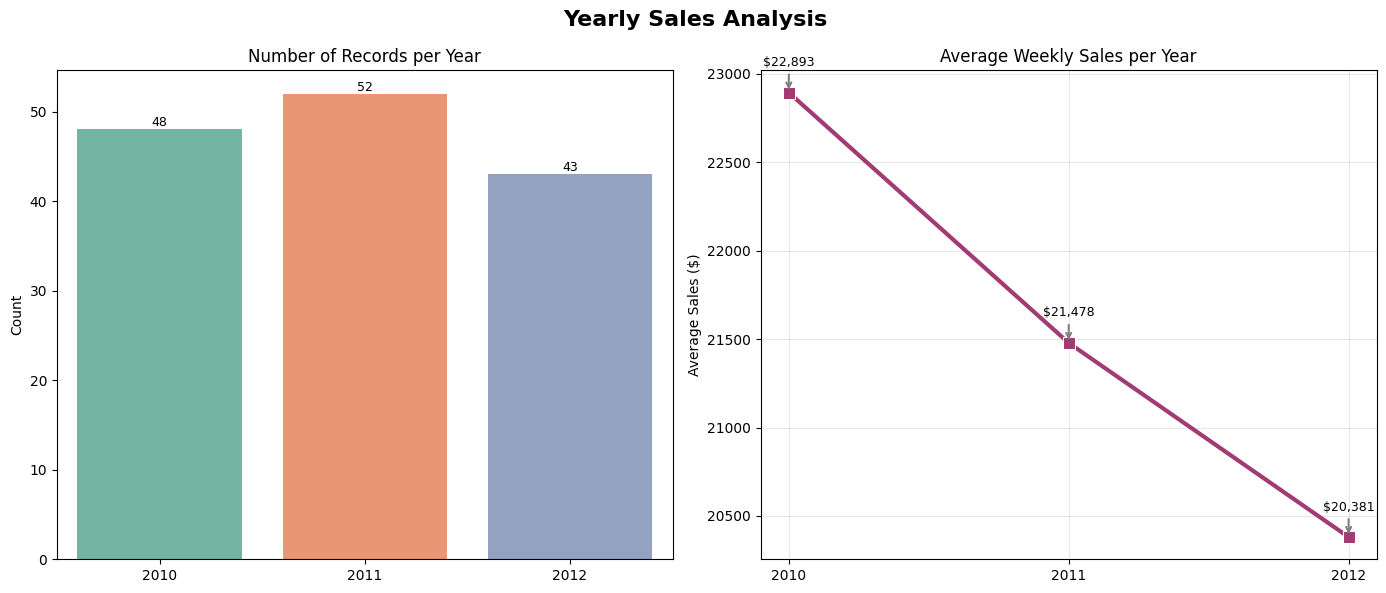

In [22]:
# Yearly Trend
years = df.index.year
yearly_sales = df.groupby(years)['Weekly_Sales'].mean()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Yearly Sales Analysis', fontsize=16, fontweight='bold')

countplot = sns.countplot(x=years, palette='Set2', ax=axes[0])
axes[0].set_title('Number of Records per Year')
axes[0].set_ylabel('Count')
axes[0].set_xlabel('')

for bar in countplot.patches:
    height = bar.get_height()
    countplot.text(bar.get_x() + bar.get_width() / 2, height,
                   f'{int(height)}', ha='center', va='bottom', fontsize=9)

lineplot = sns.lineplot(x=yearly_sales.index, y=yearly_sales.values,
                        marker='s', linewidth=3, markersize=8,
                        color='#A23B72', ax=axes[1])
axes[1].set_title('Average Weekly Sales per Year')
axes[1].set_ylabel('Average Sales ($)')
axes[1].set_xlabel('')
axes[1].set_xticks(yearly_sales.index)
axes[1].grid(True, alpha=0.3)

for year, sales in yearly_sales.items():
    lineplot.annotate(f'${sales:,.0f}', xy=(year, sales), xytext=(year, sales + 150),
                      ha='center', fontsize=9, color='black',
                      arrowprops=dict(arrowstyle='->', color='gray', lw=1.5))

plt.tight_layout()
plt.show()

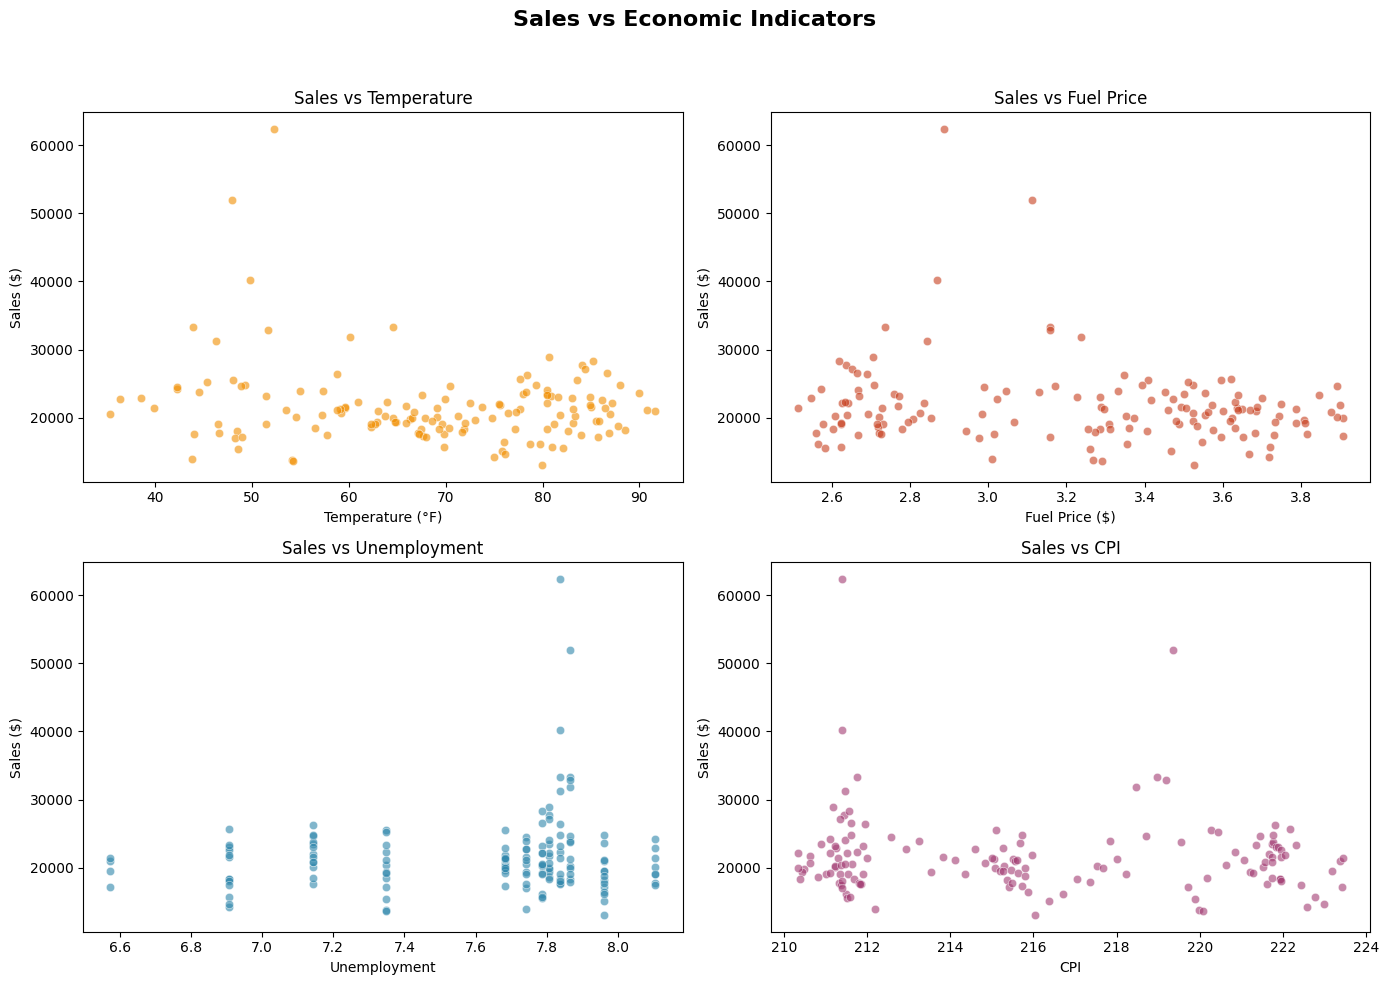

In [23]:
# Sales vs Economic Indicators
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Sales vs Economic Indicators', fontsize=16, fontweight='bold')
colors = ['#F18F01', '#C73E1D', '#2E86AB', '#A23B72']

sns.scatterplot(x='Temperature', y='Weekly_Sales', data=df,
                color=colors[0], alpha=0.6, ax=axes[0, 0])
axes[0, 0].set_title('Sales vs Temperature')
axes[0, 0].set_xlabel('Temperature (°F)')
axes[0, 0].set_ylabel('Sales ($)')

sns.scatterplot(x='Fuel_Price', y='Weekly_Sales', data=df,
                color=colors[1], alpha=0.6, ax=axes[0, 1])
axes[0, 1].set_title('Sales vs Fuel Price')
axes[0, 1].set_xlabel('Fuel Price ($)')
axes[0, 1].set_ylabel('Sales ($)')

sns.scatterplot(x='Unemployment', y='Weekly_Sales', data=df,
                color=colors[2], alpha=0.6, ax=axes[1, 0])
axes[1, 0].set_title('Sales vs Unemployment')
axes[1, 0].set_xlabel('Unemployment')
axes[1, 0].set_ylabel('Sales ($)')

sns.scatterplot(x='CPI', y='Weekly_Sales', data=df,
                color=colors[3], alpha=0.6, ax=axes[1, 1])
axes[1, 1].set_title('Sales vs CPI')
axes[1, 1].set_xlabel('CPI')
axes[1, 1].set_ylabel('Sales ($)')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

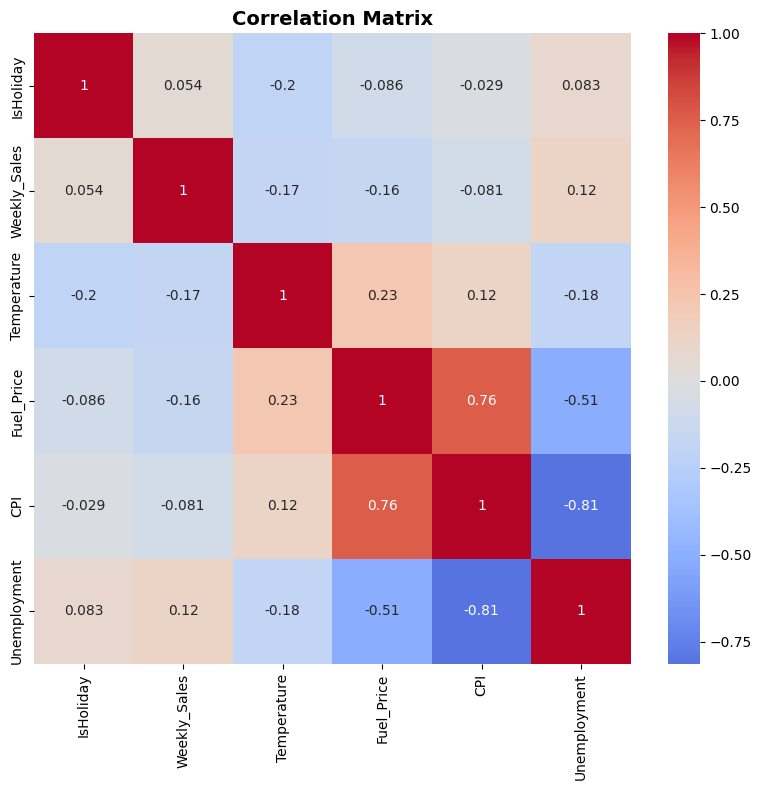

In [24]:
# Correlation Matrix
plt.figure(figsize=(8, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Time Series Analysis

## Seasonal Decomposition

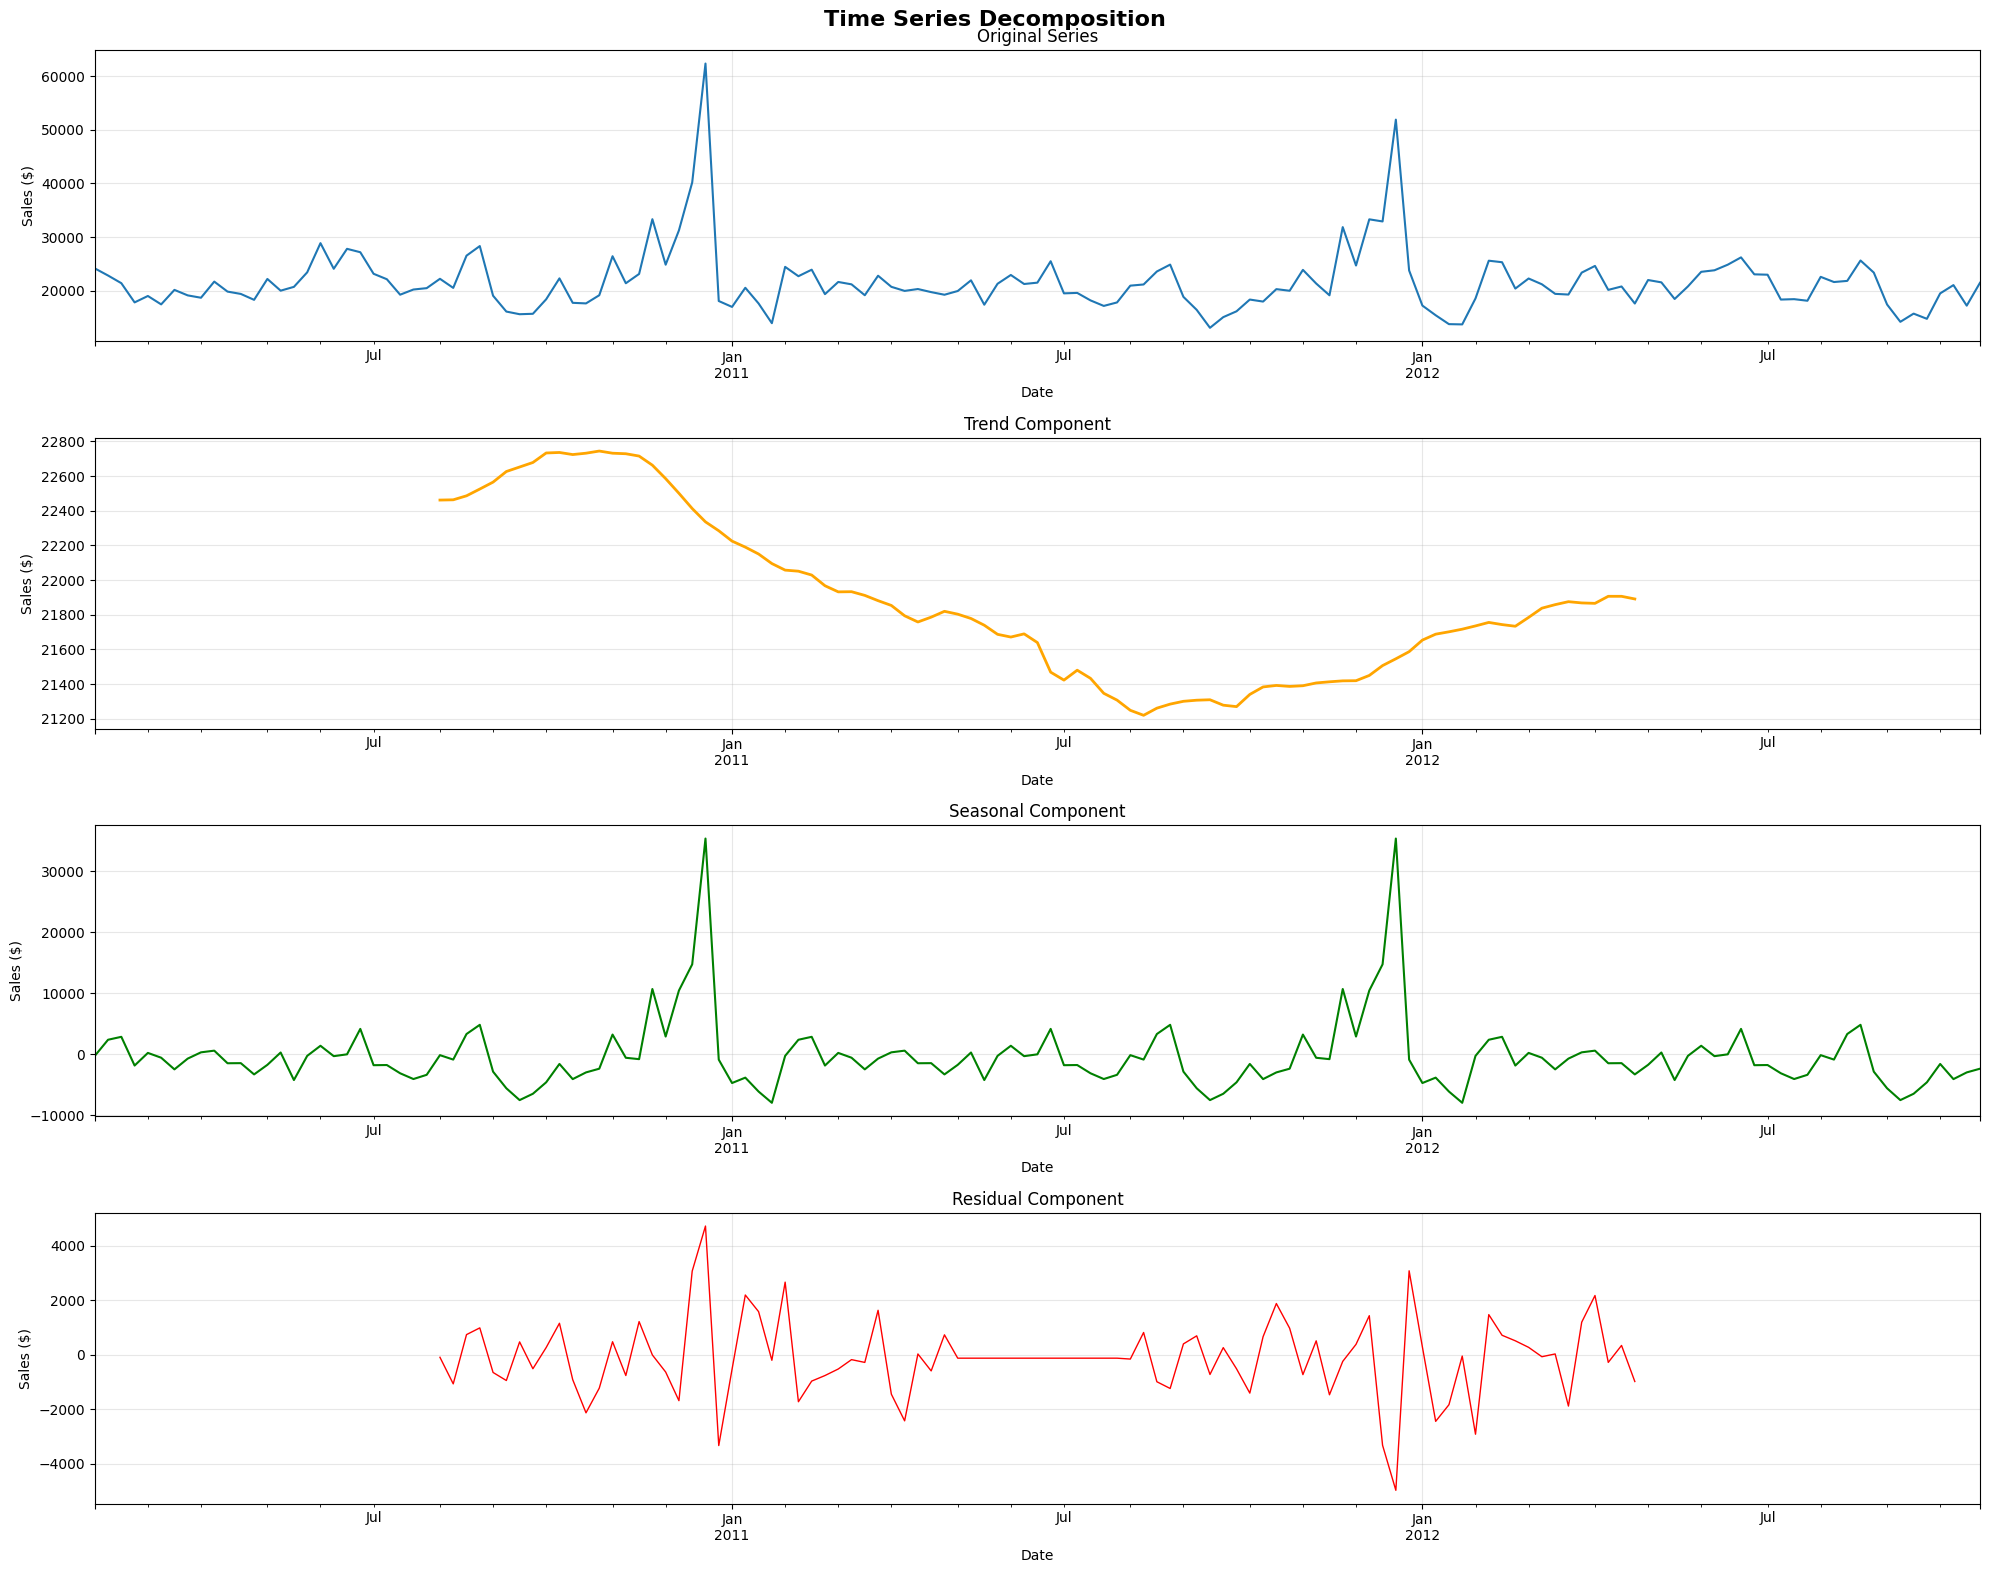

In [25]:
decomposition = seasonal_decompose(df['Weekly_Sales'], model='additive', period=52)

fig, axes = plt.subplots(4, 1, figsize=(20, 16))
fig.suptitle('Time Series Decomposition', fontsize=16, fontweight='bold')

decomposition.observed.plot(ax=axes[0], title='Original Series', linewidth=1.5)
decomposition.trend.plot(ax=axes[1], title='Trend Component', color='orange', linewidth=2)
decomposition.seasonal.plot(ax=axes[2], title='Seasonal Component', color='green', linewidth=1.5)
decomposition.resid.plot(ax=axes[3], title='Residual Component', color='red', linewidth=1)

for ax in axes:
    ax.grid(True, alpha=0.3)
    ax.set_ylabel('Sales ($)')

plt.tight_layout()
plt.show()

## ACF/PACF Analysis

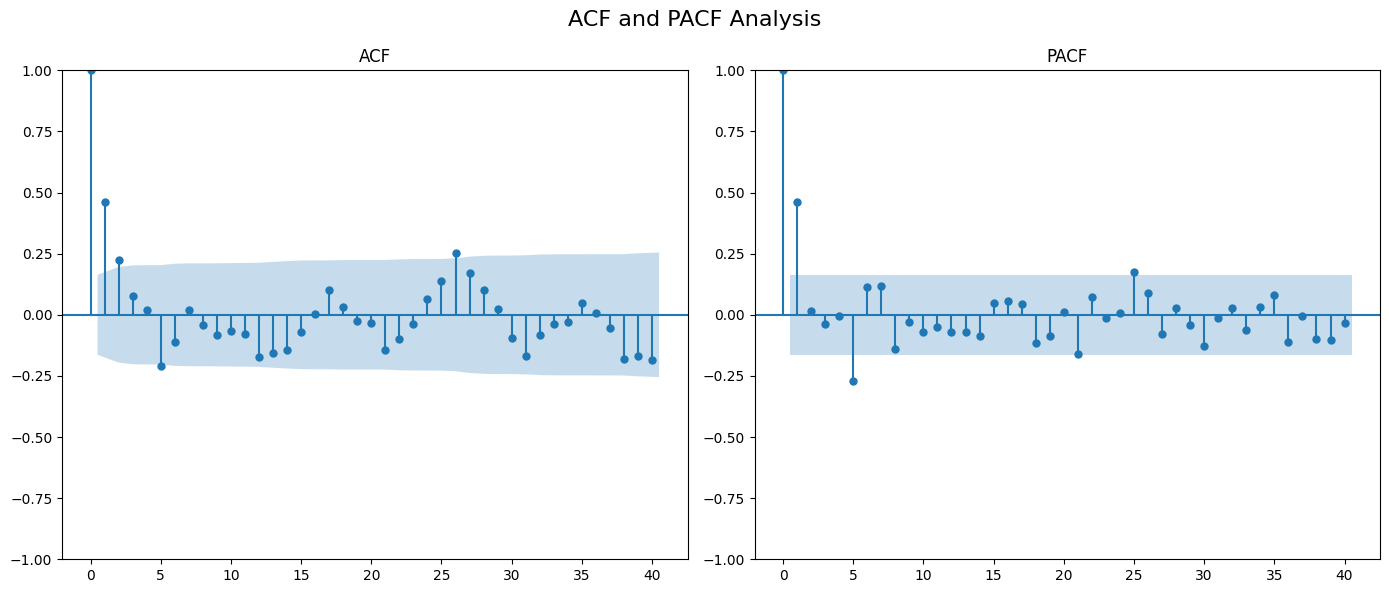

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('ACF and PACF Analysis', fontsize=16)
plot_acf(df['Weekly_Sales'].dropna(), ax=axes[0], lags=40, title='ACF')
plot_pacf(df['Weekly_Sales'].dropna(), ax=axes[1], lags=40, title='PACF')
plt.tight_layout()
plt.show()

## Stationarity Test

In [27]:
adf_result = adfuller(df['Weekly_Sales'].dropna())
print(f"p-value: {adf_result[1]:.6f}")
if adf_result[1] <= 0.05:
    print("Series is stationary")
else:
    print("Series is non-stationary")

p-value: 0.000000
Series is stationary


# Split Dataset

In [28]:
# Split data into train and test sets
period = 13 # Forecast 13 Weeks
train_data = df.iloc[:-period]
test_data = df.iloc[-period:]

print(f"Train data: {len(train_data)} samples")
print(f"Test data: {len(test_data)} samples")
print(f"Train period: {train_data.index.min()} to {train_data.index.max()}")
print(f"Test period: {test_data.index.min()} to {test_data.index.max()}")

Train data: 130 samples
Test data: 13 samples
Train period: 2010-02-05 00:00:00 to 2012-07-27 00:00:00
Test period: 2012-08-03 00:00:00 to 2012-10-26 00:00:00


In [29]:
# Initialize dictionaries to store predictions
predictions = {}
metrics = {}

In [30]:
train_data.to_csv('train_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)

# Exponential Smoothing Family Models

## Simple Exponential Smoothing

In [31]:
simple_es = ExponentialSmoothing(train_data['Weekly_Sales'],
                               trend=None, seasonal=None).fit()
predictions['Simple_ES'] = simple_es.forecast(len(test_data))

## Holt's Linear Trend (Double Exponential Smoothing)

In [32]:
holt_linear = ExponentialSmoothing(train_data['Weekly_Sales'],
                                 trend='add', seasonal=None).fit()
predictions['Holt_Linear'] =  holt_linear.forecast(len(test_data))

## Holt-Winters (Triple Exponential Smoothing)

In [33]:
holt_winters = ExponentialSmoothing(train_data['Weekly_Sales'],
                                    trend='add', seasonal='add',
                                    seasonal_periods=52).fit()
predictions['Holt_Winters'] = holt_winters.forecast(len(test_data))

# ARIMA Family Models

## ARIMA

In [34]:
arima_model = ARIMA(train_data['Weekly_Sales'], order=(1, 1, 1)).fit()
predictions['ARIMA'] = arima_model.forecast(len(test_data))

## SARIMA

In [35]:
sarima_model = SARIMAX(train_data['Weekly_Sales'],
                       order=(1, 1, 1),
                       seasonal_order=(1, 1, 1, 52)).fit()
predictions['SARIMA'] = sarima_model.forecast(len(test_data))

## SARIMAX

In [36]:
exog_cols = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday']
sarimax_model = SARIMAX(train_data['Weekly_Sales'],
                        exog=train_data[exog_cols],
                        order=(1, 1, 1),
                        seasonal_order=(1, 1, 1, 52)).fit()
predictions['SARIMAX'] = sarimax_model.forecast(len(test_data),
                                               exog=test_data[exog_cols])

# Machine Learning Models

In [37]:
X_train = train_data.drop(columns=['Weekly_Sales'])
y_train = train_data['Weekly_Sales']
X_test = test_data.drop(columns=['Weekly_Sales'])
y_test = test_data['Weekly_Sales']

In [38]:
scaler_ml = StandardScaler()
X_train_scaled = scaler_ml.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = scaler_ml.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

In [39]:
joblib.dump(scaler_ml, 'scaler_ml.pkl')

['scaler_ml.pkl']

In [40]:
def ml_random_search(model, param_dist, X_train, y_train):
    random_search = RandomizedSearchCV(model,
                                       param_distributions=param_dist,
                                       n_iter=10,
                                       cv=5,
                                       scoring='neg_mean_squared_error',
                                       n_jobs=-1,
                                       verbose=1)
    random_search.fit(X_train, y_train)
    print(f"Best parameters: {random_search.best_params_}")
    print(f"Best score: {-random_search.best_score_}")
    return random_search.best_estimator_

## Random Forest

In [41]:
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_best_model = ml_random_search(rf_model, rf_param_dist, X_train_scaled, y_train)
predictions['Random_Forest'] = rf_best_model.predict(X_test_scaled)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 10}
Best score: 43711063.32183881


## XGBoost

In [42]:
xgb_model = xgb.XGBRegressor(random_state=42, n_jobs=-1)
xgb_param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2]
}

xgb_best_model = ml_random_search(xgb_model, xgb_param_dist, X_train_scaled, y_train)
predictions['XGBoost'] = xgb_best_model.predict(X_test_scaled)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.9}
Best score: 43324366.34009255


## Gradient Boosting

In [43]:
gb_model = GradientBoostingRegressor(random_state=42)
gb_param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

gb_best_model = ml_random_search(gb_model, gb_param_dist, X_train_scaled, y_train)
predictions['Gradient_Boosting'] = gb_best_model.predict(X_test_scaled)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 5, 'learning_rate': 0.01}
Best score: 42508584.53795179


## Feature Importance

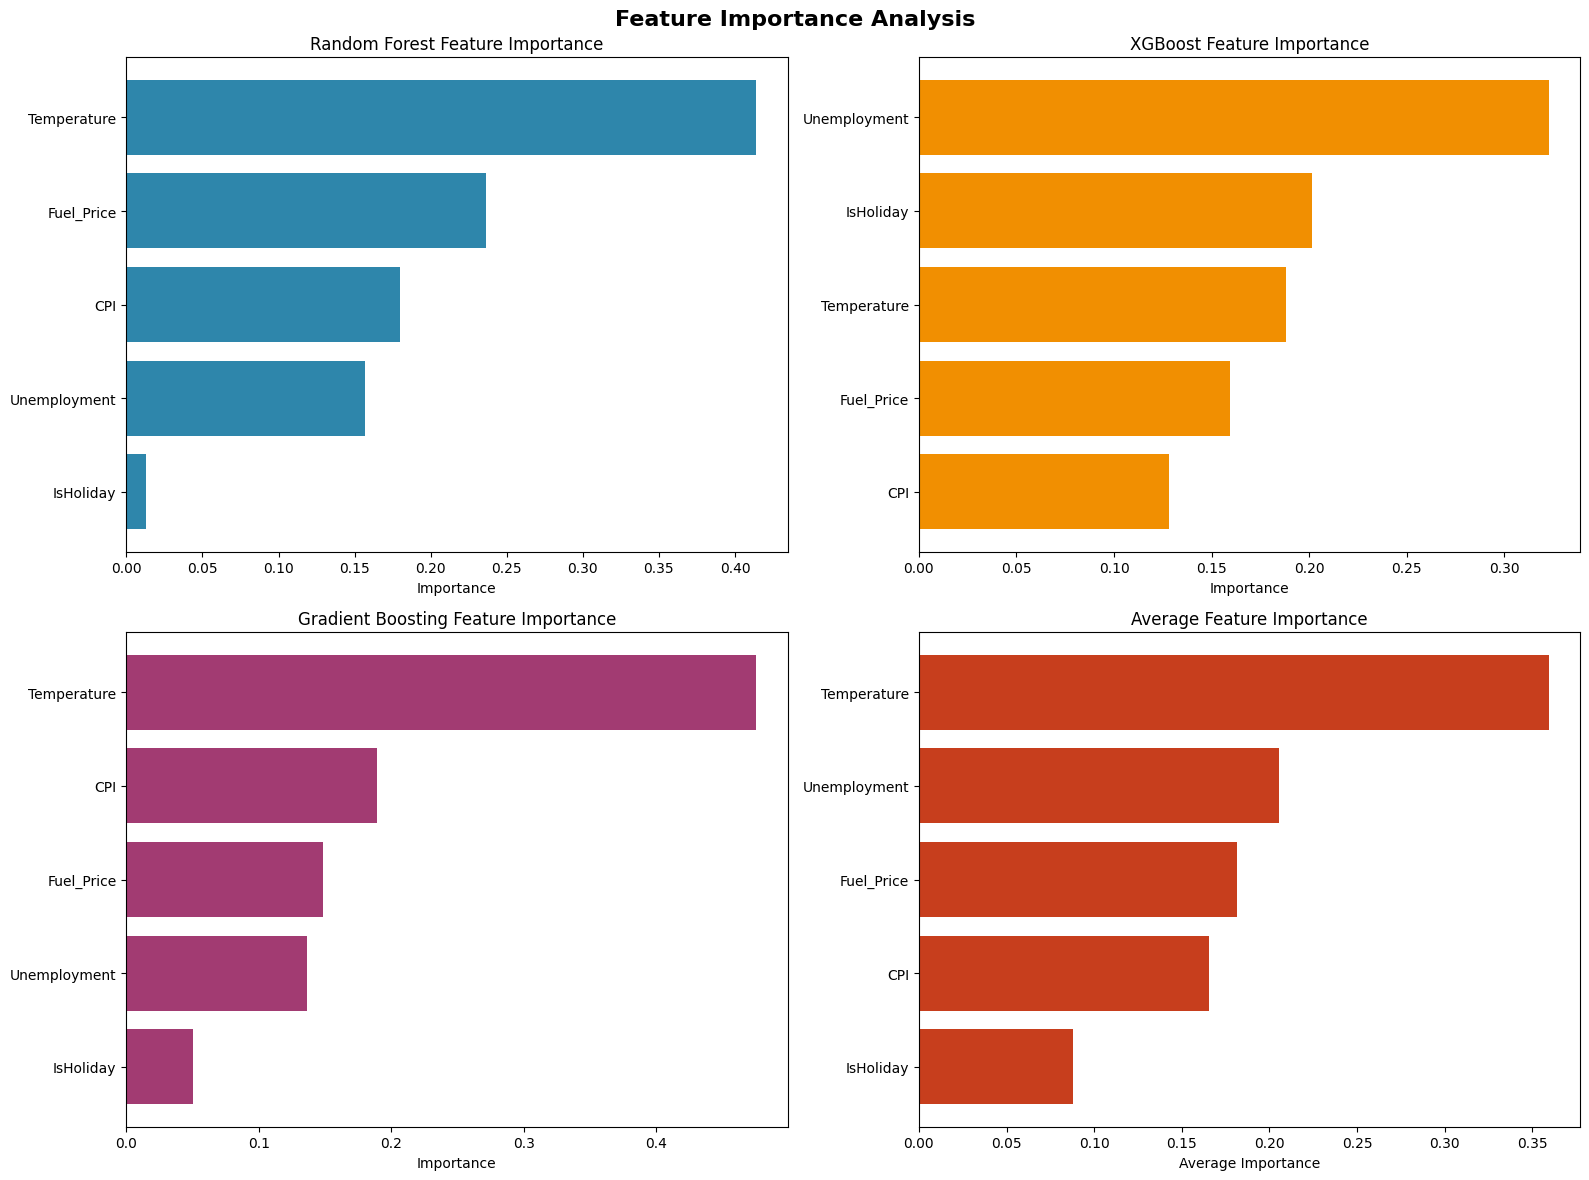

In [44]:
def plot_feature_importance(rf_model, xgb_model, gb_model, X_train):
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Feature Importance Analysis', fontsize=16, fontweight='bold')

    models = {
        'Random Forest': (rf_model.feature_importances_, axes[0, 0], '#2E86AB'),
        'XGBoost': (xgb_model.feature_importances_, axes[0, 1], '#F18F01'),
        'Gradient Boosting': (gb_model.feature_importances_, axes[1, 0], '#A23B72')
    }

    for i, (title, (importances, ax, color)) in enumerate(models.items()):
        data = pd.DataFrame({'feature': X_train.columns, 'importance': importances}).sort_values('importance')
        ax.barh(data['feature'], data['importance'], color=color)
        ax.set_title(f'{title} Feature Importance')
        ax.set_xlabel('Importance')

    avg_importance = pd.DataFrame({
        'feature': X_train.columns,
        'rf': rf_model.feature_importances_,
        'xgb': xgb_model.feature_importances_,
        'gb': gb_model.feature_importances_
    })
    avg_importance['avg'] = avg_importance[['rf', 'xgb', 'gb']].mean(axis=1)
    avg_importance.sort_values('avg', inplace=True)

    axes[1, 1].barh(avg_importance['feature'], avg_importance['avg'], color='#C73E1D')
    axes[1, 1].set_title('Average Feature Importance')
    axes[1, 1].set_xlabel('Average Importance')

    plt.tight_layout()
    plt.show()

plot_feature_importance(rf_best_model, xgb_best_model, gb_best_model, X_train_scaled)

# Deep Learning Models

In [45]:
# Scale the data
scaler_dl = StandardScaler()
scaled_data = scaler_dl.fit_transform(df[['Weekly_Sales']])

In [46]:
lookback = 13
val_weeks = 13
test_weeks = 13

In [47]:
# Create sequences
X_dl, y_dl = [], []

for i in range(lookback, len(scaled_data)):
    X_dl.append(scaled_data[i-lookback:i, 0])
    y_dl.append(scaled_data[i, 0])

X_dl, y_dl = np.array(X_dl), np.array(y_dl)

In [48]:
# Define split points
total_samples = len(X_dl)
test_start = total_samples - test_weeks
val_start = test_start - val_weeks

In [49]:
# Split the data
X_train_dl = X_dl[:val_start]
y_train_dl = y_dl[:val_start]

X_val_dl = X_dl[val_start:test_start]
y_val_dl = y_dl[val_start:test_start]

X_test_dl = X_dl[test_start:]
y_test_dl = y_dl[test_start:]

In [50]:
# Reshape for RNN/CNN
X_train_rnn = X_train_dl.reshape((X_train_dl.shape[0], X_train_dl.shape[1], 1))
X_val_rnn = X_val_dl.reshape((X_val_dl.shape[0], X_val_dl.shape[1], 1))
X_test_rnn = X_test_dl.reshape((X_test_dl.shape[0], X_test_dl.shape[1], 1))

In [51]:
joblib.dump(scaler_dl, 'scaler_dl.pkl')

['scaler_dl.pkl']

## Artificial Neural Network (ANN)

In [52]:
ann_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_dl.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

In [53]:
ann_model.compile(optimizer="adam", loss='mse', metrics=['mse'])
ann_model.fit(X_train_dl, y_train_dl, epochs=100, batch_size=8, validation_data=(X_val_dl, y_val_dl))

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 1.4887 - mse: 1.4887 - val_loss: 0.1875 - val_mse: 0.1875
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.6917 - mse: 1.6917 - val_loss: 0.1750 - val_mse: 0.1750
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.2306 - mse: 1.2306 - val_loss: 0.1615 - val_mse: 0.1615
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.2066 - mse: 1.2066 - val_loss: 0.1581 - val_mse: 0.1581
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5949 - mse: 0.5949 - val_loss: 0.1507 - val_mse: 0.1507
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8614 - mse: 0.8614 - val_loss: 0.1511 - val_mse: 0.1511
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5076 - mse: 0.5076 - val_loss: 0.1530 - val_mse: 0.1530
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5325 - mse: 0.5325 - val_loss: 0.1563 - val_mse: 0.1563
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0

In [54]:
ann_pred = ann_model.predict(X_test_dl)
predictions['ANN'] = scaler_dl.inverse_transform(ann_pred.reshape(-1, 1)).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


## RNN

In [55]:
rnn_model = Sequential([
    SimpleRNN(50, return_sequences=True, input_shape=(X_train_rnn.shape[1], 1)),
    SimpleRNN(50, activation='relu'),
    Dense(25, activation='relu'),
    Dense(1)
])

In [56]:
rnn_model.compile(optimizer="adam", loss='mse', metrics=['mse'])
rnn_model.fit(X_train_rnn, y_train_dl, epochs=100, batch_size=8, validation_data=(X_val_rnn, y_val_dl))

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 1.6215 - mse: 1.6215 - val_loss: 0.1888 - val_mse: 0.1888
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.1918 - mse: 1.1918 - val_loss: 0.2240 - val_mse: 0.2240
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.6346 - mse: 1.6346 - val_loss: 0.2298 - val_mse: 0.2298
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2606 - mse: 1.2606 - val_loss: 0.2548 - val_mse: 0.2548
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4762 - mse: 0.4762 - val_loss: 0.2447 - val_mse: 0.2447
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5696 - mse: 0.5696 - val_loss: 0.2189 - val_mse: 0.2189
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5101 - mse: 0.5101 - val_loss: 0.2102 - val_mse: 0.2102
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3386 - mse: 0.3386 - val_loss: 0.2612 - val_mse: 0.2612
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - lo

In [57]:
rnn_pred = rnn_model.predict(X_test_rnn)
predictions['RNN'] = scaler_dl.inverse_transform(rnn_pred.reshape(-1, 1)).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


## LSTM

In [58]:
lstm_model = Sequential([
    Bidirectional(LSTM(50, return_sequences=True, input_shape=(X_train_rnn.shape[1], 1))),
    Bidirectional(LSTM(50, activation='relu')),
    Dense(1)
])

In [59]:
lstm_model.compile(optimizer="adam", loss='mse', metrics=['mse'])
lstm_model.fit(X_train_rnn, y_train_dl, epochs=100, batch_size=8, validation_data=(X_val_rnn, y_val_dl))

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - loss: 0.8240 - mse: 0.8240 - val_loss: 0.1860 - val_mse: 0.1860
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.1178 - mse: 1.1178 - val_loss: 0.1813 - val_mse: 0.1813
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.8809 - mse: 0.8809 - val_loss: 0.1919 - val_mse: 0.1919
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6958 - mse: 0.6958 - val_loss: 0.2260 - val_mse: 0.2260
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.0927 - mse: 1.0927 - val_loss: 0.2214 - val_mse: 0.2214
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.8625 - mse: 0.8625 - val_loss: 0.2097 - val_mse: 0.2097
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5985 - mse: 0.5985 - val_loss: 0.2495 - val_mse: 0.2495
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.9952 - mse: 0.9952 - val_loss: 0.2265 - val_mse: 0.2265
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - lo

In [60]:
lstm_pred = lstm_model.predict(X_test_rnn)
predictions['LSTM'] = scaler_dl.inverse_transform(lstm_pred.reshape(-1, 1)).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step


## GRU

In [61]:
gru_model = Sequential([
    GRU(50, return_sequences=True, input_shape=(X_train_rnn.shape[1], 1)),
    GRU(50, activation='relu'),
    Dense(1)
])

In [62]:
gru_model.compile(optimizer="adam", loss='mse', metrics=['mse'])
gru_model.fit(X_train_rnn, y_train_dl, epochs=100, batch_size=8, validation_data=(X_val_rnn, y_val_dl))

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 1.0933 - mse: 1.0933 - val_loss: 0.1830 - val_mse: 0.1830
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.0976 - mse: 1.0976 - val_loss: 0.1769 - val_mse: 0.1769
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.1474 - mse: 1.1474 - val_loss: 0.1666 - val_mse: 0.1666
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.7440 - mse: 0.7440 - val_loss: 0.1514 - val_mse: 0.1514
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.3521 - mse: 1.3521 - val_loss: 0.1368 - val_mse: 0.1368
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.2341 - mse: 1.2341 - val_loss: 0.1367 - val_mse: 0.1367
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.8235 - mse: 1.8235 - val_loss: 0.1159 - val_mse: 0.1159
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.3069 - mse: 1.3069 - val_loss: 0.1477 - val_mse: 0.1477
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - lo

In [63]:
gru_pred = gru_model.predict(X_test_rnn)
predictions['GRU'] = scaler_dl.inverse_transform(gru_pred.reshape(-1, 1)).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


## CNN

In [64]:
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_dl.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(25, activation='relu'),
    Dense(1)
])

In [65]:
cnn_model.compile(optimizer="adam", loss='mse', metrics=['mse'])
cnn_model.fit(X_train_rnn, y_train_dl, epochs=100, batch_size=8, validation_data=(X_val_rnn, y_val_dl))

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.5733 - mse: 0.5733 - val_loss: 0.1827 - val_mse: 0.1827
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4021 - mse: 1.4021 - val_loss: 0.1877 - val_mse: 0.1877
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.5147 - mse: 1.5147 - val_loss: 0.1863 - val_mse: 0.1863
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6209 - mse: 0.6209 - val_loss: 0.1836 - val_mse: 0.1836
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1950 - mse: 1.1950 - val_loss: 0.1928 - val_mse: 0.1928
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6883 - mse: 1.6883 - val_loss: 0.1937 - val_mse: 0.1937
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9860 - mse: 0.9860 - val_loss: 0.2157 - val_mse: 0.2157
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2194 - mse: 1.2194 - val_loss: 0.2153 - val_mse: 0.2153
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1

In [66]:
cnn_pred = cnn_model.predict(X_test_rnn)
predictions['CNN'] = scaler_dl.inverse_transform(cnn_pred.reshape(-1, 1)).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


# Prophet

In [67]:
prophet_train = train_data.reset_index()
prophet_train.columns = ['ds', 'IsHoliday', 'y', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

prophet_test = test_data.reset_index()
prophet_test.columns = ['ds', 'IsHoliday', 'y', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

In [68]:
holidays = prophet_train[prophet_train['IsHoliday'] == 1][['ds']].copy()
holidays['holiday'] = 'walmart_holiday'
holidays['lower_window'] = 0
holidays['upper_window'] = 0

In [69]:
prophet_model = Prophet(
    holidays=holidays,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='additive'
)

regressor_cols = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
for col in regressor_cols:
    prophet_model.add_regressor(col)

prophet_model.fit(prophet_train[['ds', 'y'] + regressor_cols])

DEBUG:cmdstanpy:input tempfile: /tmp/tmp33i44l1g/1kchky_u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp33i44l1g/p21bd52o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34195', 'data', 'file=/tmp/tmp33i44l1g/1kchky_u.json', 'init=/tmp/tmp33i44l1g/p21bd52o.json', 'output', 'file=/tmp/tmp33i44l1g/prophet_modelvfpet3ws/prophet_model-20250626134913.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:49:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:49:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [70]:
future_df = prophet_train[['ds'] + regressor_cols].copy()
future_df = pd.concat([
    future_df,
    prophet_test[['ds'] + regressor_cols]
], ignore_index=True)

In [71]:
profit_pred = prophet_model.predict(future_df)
predictions['Prophet'] = profit_pred.tail(len(test_data))['yhat'].values

# N-BEATS

In [72]:
df_nbeats = df.reset_index().copy()
df_nbeats['unique_id'] = 'store_23'
df_nbeats.rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'}, inplace=True)

In [ ]:
exog_cols = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday']
horizon = len(test_data)

In [73]:
scaler_nbeats = StandardScaler()
df_nbeats[exog_cols] = scaler_nbeats.fit_transform(df_nbeats[exog_cols])
df_nbeats = df_nbeats[['unique_id', 'ds', 'y'] + exog_cols]

In [75]:
nbeats_model = NeuralForecast(
    models=[
        NBEATSx(
            input_size=5 * horizon,
            h=horizon,
            max_steps=100,
            val_check_steps=10,
            scaler_type='robust',
            loss=MSE(),
            futr_exog_list=exog_cols,
            batch_size=8
        )
    ],
    freq='W'
)
nbeats_model.fit(df_nbeats, val_size=horizon)

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MSE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 3.1 M  | train
-------------------------------------------------------
3.1 M     Trainable params
2.1 K     Non-trainable params
3.1 M     Total params
12.537    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.


In [76]:
futr_df = nbeats_model.make_future_dataframe()

future_exog = test_data.reset_index().copy()
future_exog['unique_id'] = 'store_23'
future_exog.rename(columns={'Date': 'ds'}, inplace=True)
future_exog[exog_cols] = scaler_nbeats.transform(future_exog[exog_cols])
future_exog = future_exog[['unique_id', 'ds'] + exog_cols]

futr_df = futr_df.merge(future_exog, on=['unique_id', 'ds'], how='left')

In [77]:
missing = futr_df[exog_cols].isna().sum()
if missing.any():
    futr_df[exog_cols] = futr_df[exog_cols].fillna(method='ffill').fillna(0)

In [78]:
forecast_nbeats = nbeats_model.predict(futr_df=futr_df)
predictions['NBEATS'] = forecast_nbeats['NBEATSx'].values

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

In [79]:
joblib.dump(scaler_nbeats, 'scaler_nbeats.pkl')

['scaler_nbeats.pkl']

# Evaluation & Comparison

In [86]:
def evaluate_models(predictions, test_series):

    results = {}
    for model_name, pred in predictions.items():
        actual = test_series.values[:len(pred)]
        rmse = np.sqrt(mean_squared_error(actual, pred))
        mae = mean_absolute_error(actual, pred)
        mape = mean_absolute_percentage_error(actual, pred) * 100
        results[model_name] = {'RMSE': rmse, 'MAE': mae, 'MAPE (%)': mape}
    return pd.DataFrame(results).T.sort_values('RMSE')

metrics_df = evaluate_models(predictions, test_data['Weekly_Sales'])
print("Model Performance Metrics:")
print(metrics_df.round(2))

Model Performance Metrics:
                      RMSE      MAE  MAPE (%)
ANN                1742.81  1514.27      7.66
GRU                1838.79  1565.08      8.16
SARIMA             1914.88  1528.89      7.73
LSTM               1985.23  1623.12      8.80
RNN                2290.92  2003.58     10.79
Prophet            2368.84  1895.42     10.38
Holt_Winters       2481.08  2053.63     10.40
CNN                2583.93  2150.72     11.46
SARIMAX            2848.43  2217.56     11.19
XGBoost            3533.39  2755.72     15.97
Simple_ES          3543.49  3180.68     16.42
Gradient_Boosting  3618.56  2841.44     16.17
Random_Forest      3684.84  2844.74     16.71
ARIMA              3945.98  3170.46     18.42
Holt_Linear        4825.21  4059.71     19.11
NBEATS             9371.49  6615.90     39.33


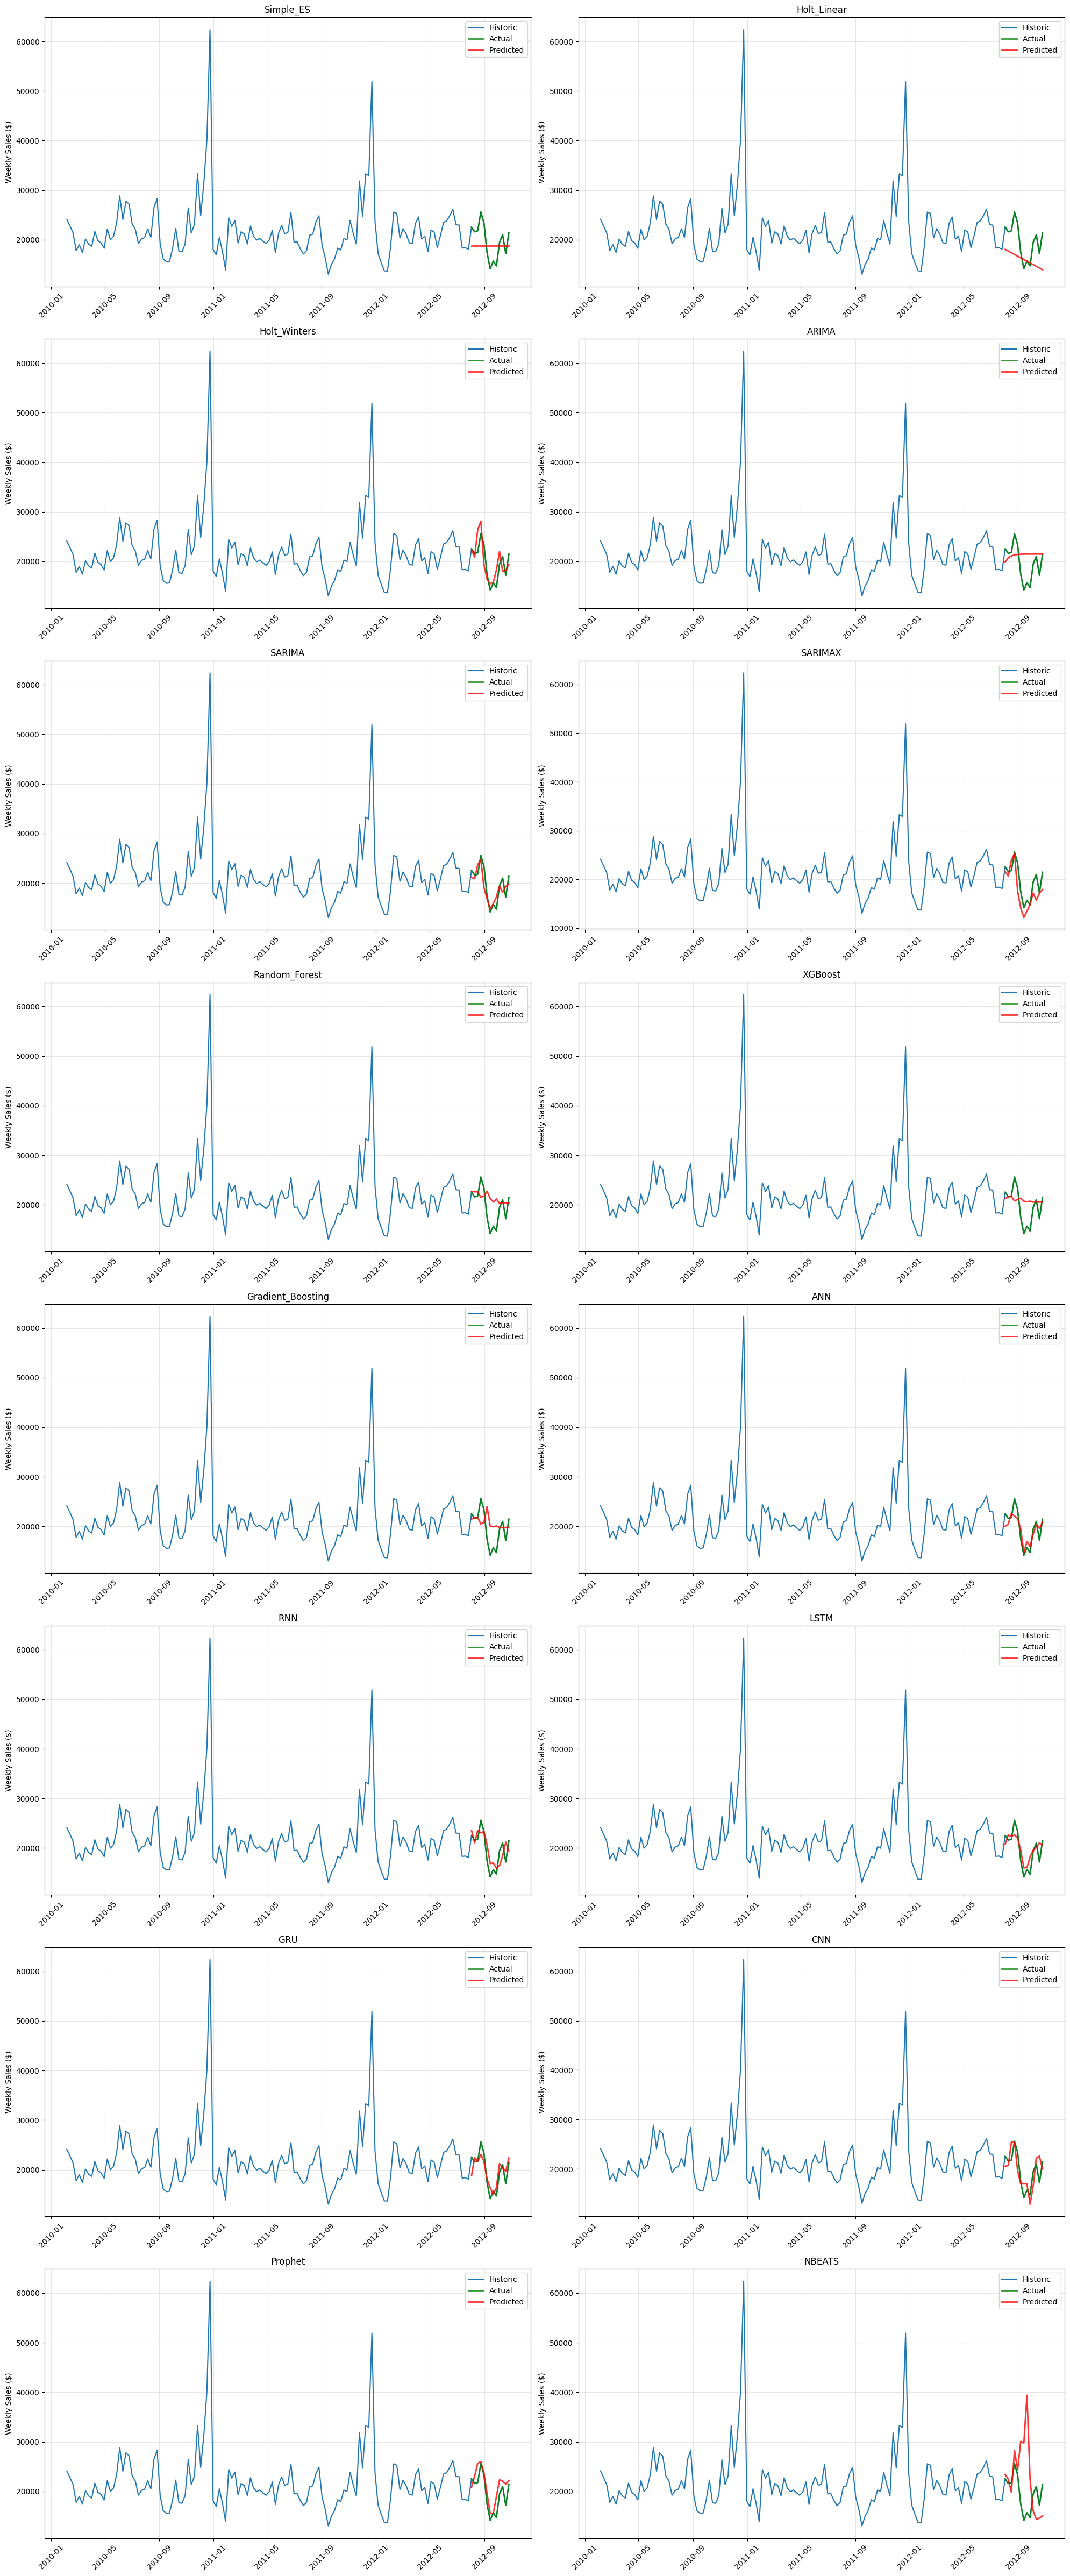

In [81]:
def plot_individual_predictions(predictions, train_data, test_data, metrics_df):

    n_models = len(predictions)
    n_cols = 2
    n_rows = (n_models + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6 * n_rows))
    if n_rows == 1:
        axes = [axes] if n_models == 1 else axes
    else:
        axes = axes.flatten()

    for idx, (model_name, pred) in enumerate(predictions.items()):
        ax = axes[idx]
        pred_index = test_data.index[:len(pred)]

        full_actual_index = train_data.index.append(test_data.index)
        full_actual_values = np.concatenate([train_data['Weekly_Sales'].values, test_data['Weekly_Sales'].values])

        ax.plot(full_actual_index, full_actual_values,
               label='Historic', linewidth=1.5)

        ax.plot(test_data.index, test_data['Weekly_Sales'],
               label='Actual', color='green', linewidth=2, alpha=0.8)

        ax.plot(pred_index, pred,
               label='Predicted', color='red', linewidth=2, alpha=0.8)

        ax.set_title(f'{model_name}', fontsize=12)
        ax.set_ylabel('Weekly Sales ($)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)

    for idx in range(n_models, len(axes)):
        axes[idx].set_visible(False)

    plt.tight_layout()
    plt.show()

plot_individual_predictions(predictions, train_data, test_data, metrics_df)

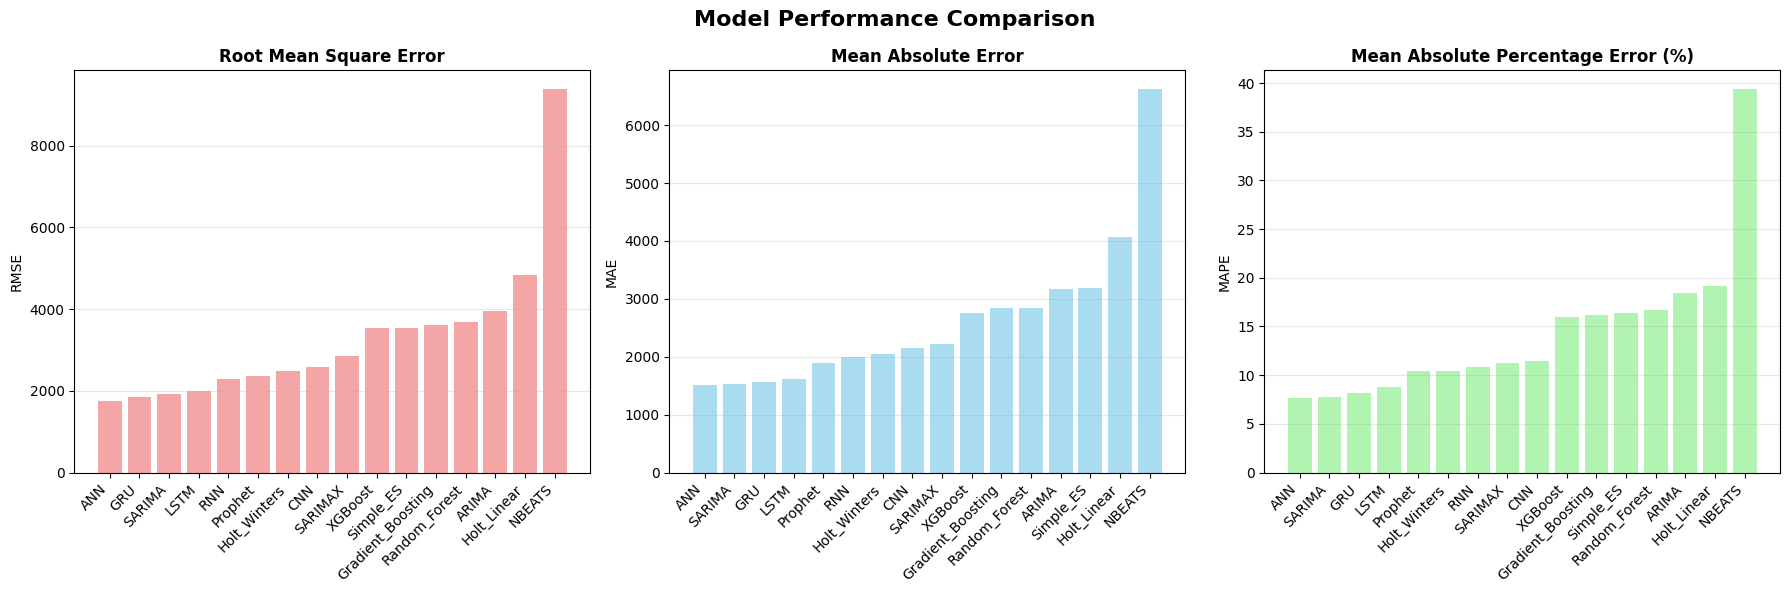

In [82]:
def plot_ordered_metrics(metrics_df):

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

    metrics_info = [
        ('RMSE', 'Root Mean Square Error', 'lightcoral'),
        ('MAE', 'Mean Absolute Error', 'skyblue'),
        ('MAPE', 'Mean Absolute Percentage Error (%)', 'lightgreen')
    ]

    for i, (metric, title, color) in enumerate(metrics_info):
        ax = axes[i]

        sorted_data = metrics_df[metric].sort_values(ascending=True)
        bars = ax.bar(range(len(sorted_data)), sorted_data.values, color=color, alpha=0.7)
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.set_ylabel(metric)
        ax.set_xticks(range(len(sorted_data)))
        ax.set_xticklabels(sorted_data.index, rotation=45, ha='right')

        ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

plot_ordered_metrics(metrics_df)

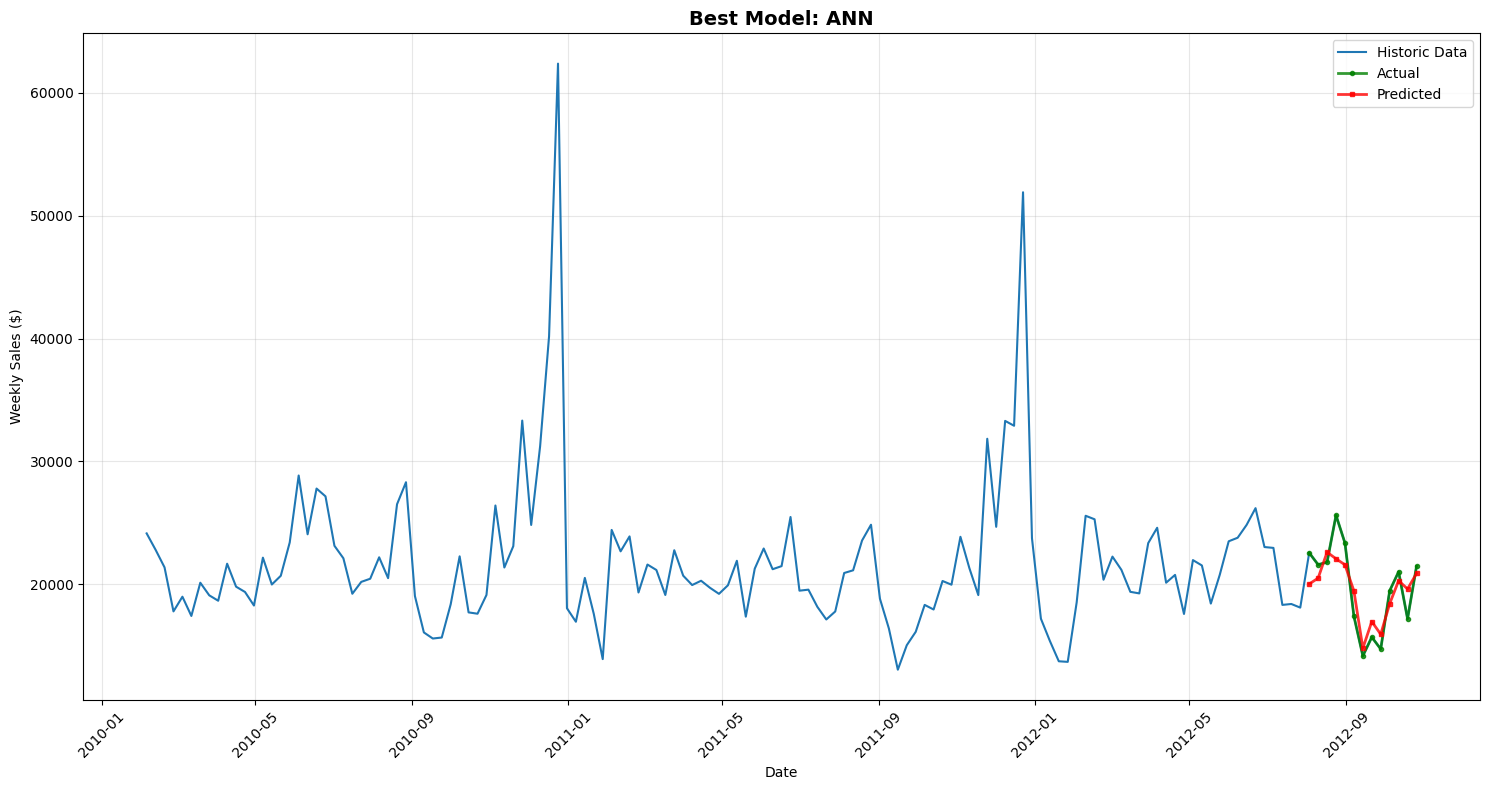


BEST PERFORMING MODEL: ANN
RMSE: 1742.8080
MAE: 1514.2750
MAPE: 7.6585


In [83]:
def plot_best_model_detailed(train_data, test_data, predictions, metrics_df):

    best_model = metrics_df.index[0]
    best_pred = predictions[best_model]
    plt.figure(figsize=(15, 8))

    pred_index = test_data.index[:len(best_pred)]

    full_actual_index = train_data.index.append(test_data.index)
    full_actual_values = np.concatenate([train_data['Weekly_Sales'].values, test_data['Weekly_Sales'].values])

    plt.plot(full_actual_index, full_actual_values,
             label='Historic Data', linewidth=1.5)

    plt.plot(test_data.index, test_data['Weekly_Sales'],
             label='Actual', color='green', linewidth=2, marker='o', markersize=3, alpha=0.8)

    plt.plot(pred_index, best_pred,
             label=f'Predicted', color='red', linewidth=2,
             marker='s', markersize=3, alpha=0.8)

    plt.title(f'Best Model: {best_model}',
              fontsize=14, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Weekly Sales ($)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print(f"\n{'='*50}")
    print(f"BEST PERFORMING MODEL: {best_model}")
    print(f"{'='*50}")
    for metric in metrics_df.columns:
        value = metrics_df.loc[best_model, metric]
        print(f"{metric}: {value:.4f}")
    print(f"{'='*50}")

plot_best_model_detailed(train_data, test_data, predictions, metrics_df)

# Save Best Model

In [84]:
metrics = {}

for name, pred in predictions.items():
    metrics[name] = np.sqrt(mean_squared_error(y_test, pred))

best_model_name = min(metrics, key=metrics.get)
print(f"Best model: {best_model_name}\nRMSE: {metrics[best_model_name]:.2f}")

pkl_models = {
    'Prophet': prophet_model,
    'Random_Forest': rf_best_model,
    'XGBoost': xgb_best_model,
    'Gradient_Boosting': gb_best_model,
    'Simple_ES': simple_es,
    'Holt_Linear': holt_linear,
    'Holt_Winters': holt_winters,
    'ARIMA': arima_model,
    'SARIMA': sarima_model,
    'SARIMAX': sarimax_model
}

h5_models = {
    'ANN': ann_model,
    'RNN': rnn_model,
    'LSTM': lstm_model,
    'GRU': gru_model,
    'CNN': cnn_model
}

neuralforecast_models = {
    'NBEATSx': nbeats_model
}

if best_model_name in pkl_models:
    with open("model.pkl", "wb") as f:
        pickle.dump(pkl_models[best_model_name], f)
    print("Model saved as model.pkl")

elif best_model_name in h5_models:
    h5_models[best_model_name].save("model.h5")
    print("Model saved as model.h5")

elif best_model_name in neuralforecast_models:
    neuralforecast_models[best_model_name].save(path='model_nbeatsx')
    print("Model saved in folder: model_nbeatsx")

else:
    print("Could not identify model for saving.")

Best model: ANN
RMSE: 1742.81
Model saved as model.h5
